In [1]:
import pandas as pd
import rasterio
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import yaml
config_path = '/home/tu/tu_tu/tu_zxmav84/DS_Project/modules/config.yml'
with open(config_path, 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

sentinel_path = config['data']['sentinel']
config

{'data': {'workspace': None,
  'data': '/pfs/work7/workspace/scratch/tu_zxmav84-ds_project/data',
  'orthophotos': '/pfs/work7/workspace/scratch/tu_zxmav84-ds_project/data/orthophotos',
  'building_boxes': '/pfs/work7/workspace/scratch/tu_zxmav84-ds_project/data/building_boxes',
  'dwd': '/pfs/work7/workspace/scratch/tu_zxmav84-ds_project/data/DWD',
  'sentinel': '/pfs/work7/workspace/scratch/tu_zxmav84-ds_project/data/sentinel',
  'landsat': '/pfs/work7/workspace/scratch/tu_zxmav84-ds_project/data/landsat'},
 'bboxes': {'munich': [11.31079, 47.980475, 11.855986, 48.385189]}}

In [3]:
# Unzip file
import zipfile
filepath = sentinel_path+'/raw_scenes/S2B_MSIL2A_20220811T100559_N0400_R022_T32UPU_20220811T162101.zip'
with zipfile.ZipFile(filepath, 'r') as zip_ref:
    zip_ref.extractall(sentinel_path+'/raw_scenes/')

## Read in the data

In [4]:
# Define file paths
base_path = sentinel_path + '/raw_scenes/S2B_MSIL2A_20220811T100559_N0400_R022_T32UPU_20220811T162101.SAFE/GRANULE/L2A_T32UPU_A028362_20220811T101510/IMG_DATA/R10m/'
true_color_file = base_path + 'T32UPU_20220811T100559_TCI_10m.jp2'
red_file = base_path + 'T32UPU_20220811T100559_B04_10m.jp2'
blue_file = base_path + 'T32UPU_20220811T100559_B02_10m.jp2'
nir_file = base_path + 'T32UPU_20220811T100559_B08_10m.jp2'


In [5]:
# Read in data
# Open the true color image using rasterio
with rasterio.open(true_color_file) as src:
    true_color = src.read()

# Open the red, NIR, and blue bands using rasterio
with rasterio.open(red_file) as src:
    red = src.read()
with rasterio.open(nir_file) as src:
    nir = src.read()
with rasterio.open(blue_file) as src:
    blue = src.read()


## Calculate Vegetation Indices

In [6]:
# Replace NaN and Inf values with zero
nir = np.nan_to_num(nir, 0)
red = np.nan_to_num(red, 0)
# Calculate the NDVI index
ndvi = (nir - red) / (nir + red)

# Calculate the EVI index
g = 2.5
c1 = 6
c2 = 7.5
l = 1
denominator = nir + c1 * red - c2 * blue + l
denominator[denominator == 0] = 0.0001  # Add a small constant to avoid divide by zero
evi = g * ((nir - red) / denominator)

/scratch/slurm_tmpdir/job_22243589/ipykernel_284089/2435705542.py:5: RuntimeWarning: invalid value encountered in divide
  ndvi = (nir - red) / (nir + red)


Text(0.5, 1.0, 'EVI')

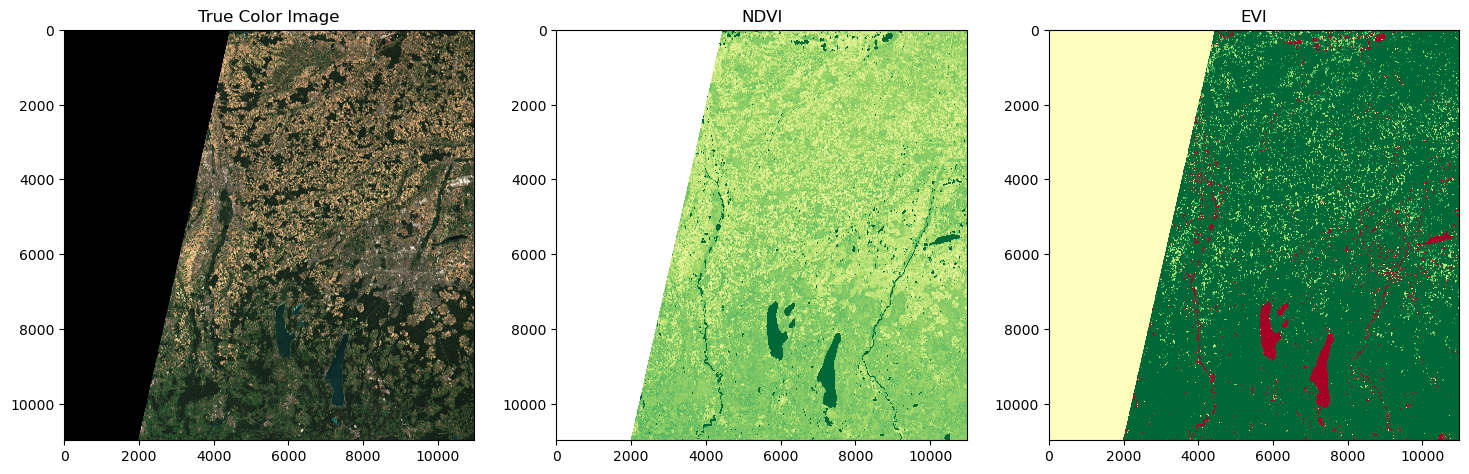

In [7]:
fig, ax = plt.subplots(1,3,figsize=(18, 6))
# Plot tre color
ax[0].imshow(np.transpose(true_color, [1, 2, 0]))
ax[0].set_title('True Color Image')

# Plot the NDVI index
ax[1].imshow(np.squeeze(ndvi), cmap='RdYlGn', vmin=-1, vmax=1)
ax[1].set_title('NDVI')
# Plot the EVI index
ax[2].imshow(np.squeeze(evi), cmap='RdYlGn', vmin=-1, vmax=1)
ax[2].set_title('EVI')

## Crop Munich City

In [8]:
from rasterio.windows import Window
bbox_4326 = (11.576947,48.128678,11.604069,48.149555)
import rasterio.warp
[xmin, xmax], [ymin, ymax] = rasterio.warp.transform('EPSG:4326', 'EPSG:32632', [bbox_4326[0], bbox_4326[2]], [bbox_4326[1], bbox_4326[3]])
bbox = (xmin, ymin, xmax, ymax)
bbox

(691743.1613381845, 5333814.307467337, 693682.4898493877, 5336202.480574397)

In [9]:
# Read in the true color image and crop to the bounding box
with rasterio.open(true_color_file) as src:
    window = src.window(*bbox)
    true_color = src.read(window=window)
# Open the red, NIR, and blue bands using rasterio and crop to the bounding box
with rasterio.open(red_file) as src:
    window = src.window(*bbox)
    red = src.read(window=window)
with rasterio.open(nir_file) as src:
    window = src.window(*bbox)
    nir = src.read(window=window)
with rasterio.open(blue_file) as src:
    window = src.window(*bbox)
    blue = src.read(window=window)

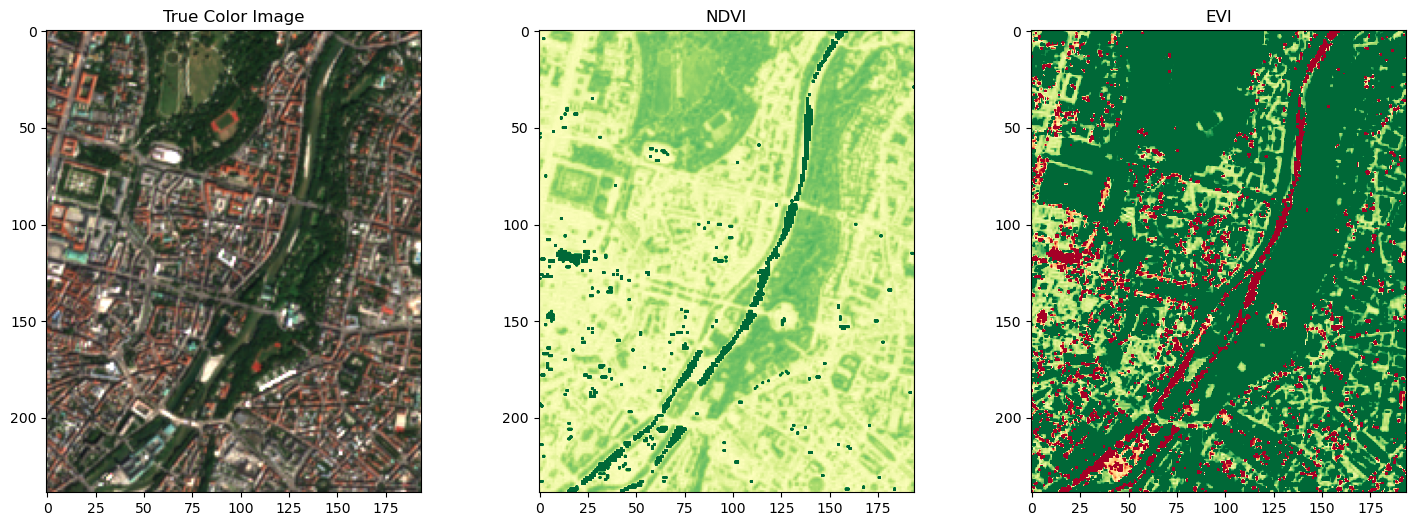

In [10]:
# Calculate the NDVI index
ndvi = (nir - red) / (nir + red)

# Calculate the EVI index
g = 2.5
c1 = 6
c2 = 7.5
l = 1
denominator = nir + c1 * red - c2 * blue + l
denominator[denominator == 0] = 0.0001  # Add a small constant to avoid divide by zero
evi = g * ((nir - red) / denominator)


fig, ax = plt.subplots(1,3,figsize=(18, 6))
# Plot tre color
ax[0].imshow(np.transpose(true_color, [1, 2, 0]))
ax[0].set_title('True Color Image')

# Plot the NDVI index
ax[1].imshow(np.squeeze(ndvi), cmap='RdYlGn', vmin=-1, vmax=1)
ax[1].set_title('NDVI')
# Plot the EVI index
ax[2].imshow(np.squeeze(evi), cmap='RdYlGn', vmin=-1, vmax=1)
ax[2].set_title('EVI')
fig.savefig('munich_sentinel_ndvi.png')